(8155, 3)
(7000, 3)
(6825, 3)


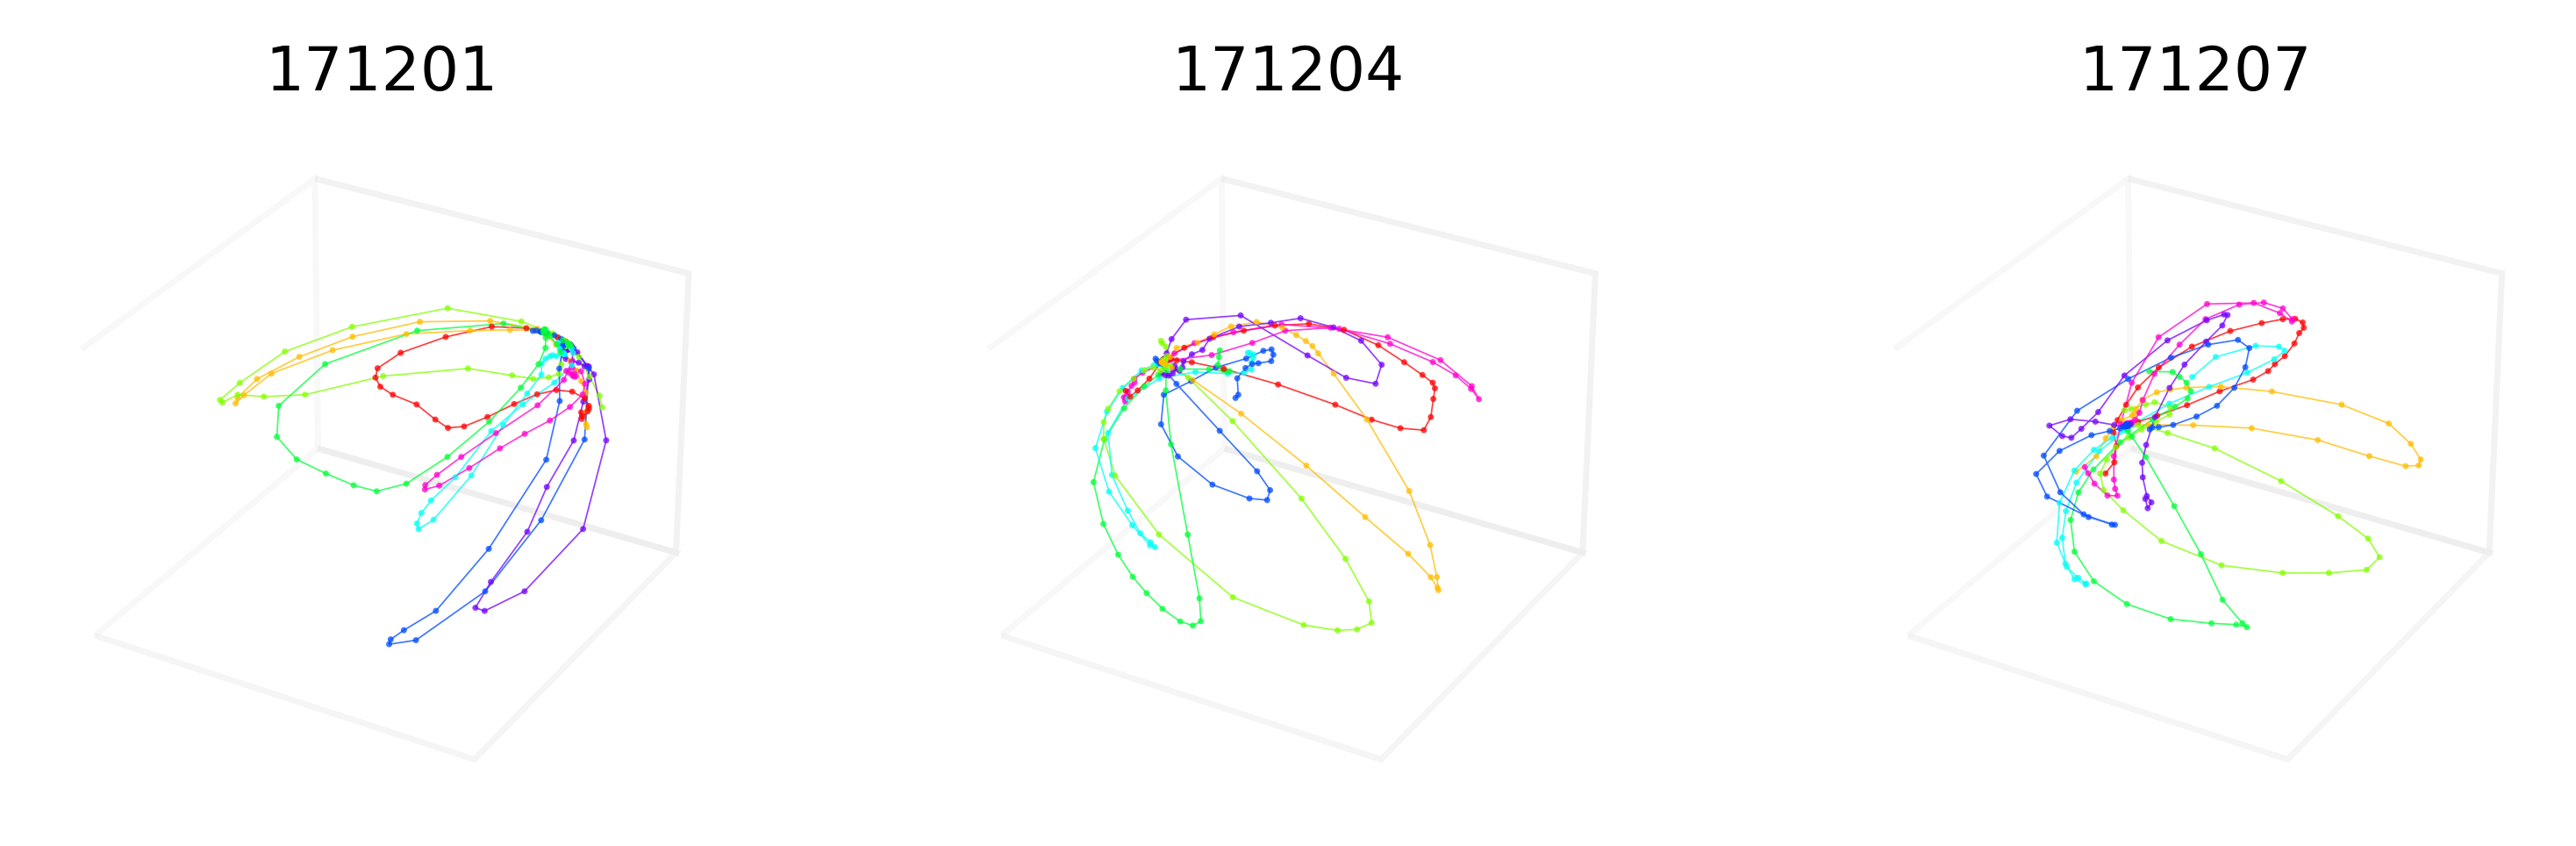

In [1]:
import os, re
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import orthogonal_procrustes

dur = 35
emb_dim = 3
N_angles = 8
idx1, idx2, idx3 = 0, 1, 2

name_range = slice(-28, -22)

directory = './data_NER/S1 3/NER_Han2017/NPZ/'
files = [os.path.join(directory, f) for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]
n_file = len(files)
def list_and_sort_files(directory):
    files = [os.path.join(directory, f) for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]
    def extract_date(filename):
        # This regex matches 6 consecutive digits that likely represent a date in YYMMDD format
        match = re.search(r'(\d{6})', os.path.basename(filename))
        date = match.group(0) if match else '000000'  # Default to '000000' if no date is found
        # Standardize to YYMMDD if necessary
        year_prefix = '20'  # assuming all dates are after the year 2000
        return int(year_prefix + date) if len(date) == 6 else int(date)
    sorted_files = sorted(files, key=extract_date)
    return sorted_files
sorted_files=list_and_sort_files(directory)
##print("Reading file sequence:", sorted_files)

def get_best_R(R_all, emb_A_8angle_align):
    determinants = [np.linalg.det(R_all[:, :, i]) for i in range(R_all.shape[2])]
    positive_dets = [det for det in determinants if det >= 0]
    negative_dets = [det for det in determinants if det < 0]

    if len(positive_dets)>0:
        target_dets = positive_dets
        differences = [abs(abs(det) - 1) for det in target_dets]
        min_index = np.argmin(differences)
        best_R_index_p = determinants.index(positive_dets[min_index])
        best_R_p = R_all[:, :, best_R_index_p]
        emb_A_whole_align_p = np.matmul(emb_A, best_R_p)
        align_diff_p = np.sum(abs(emb_A_whole_align_p-emb_A_8angle_align))
        ## print('diff positive detR=', align_diff_p)
    elif len(positive_dets) == 0:
        align_diff_p = 5000000 ### arbitory value
        
    if len(negative_dets)>0:
        target_dets = negative_dets
        differences = [abs(abs(det) - 1) for det in target_dets]
        min_index = np.argmin(differences)
        best_R_index_n = determinants.index(negative_dets[min_index])
        best_R_n = R_all[:, :, best_R_index_n]
        emb_A_whole_align_n = np.matmul(emb_A, best_R_n)
        align_diff_n = np.sum(abs(emb_A_whole_align_n-emb_A_8angle_align))
        ## print('diff negative detR=', align_diff_n)
    elif len(negative_dets) == 0:
        align_diff_n = 5000000
        
    if align_diff_p<align_diff_n:
        best_R = best_R_p
        ## print('Using positive R')
    elif align_diff_p>align_diff_n:
        best_R = best_R_n
        ## print('Using negative R')
    return best_R


fig = plt.figure(figsize=(8, 2), dpi=500)
emb_avg_4D = np.zeros((dur, emb_dim, N_angles, n_file))
for f, file in enumerate(sorted_files):
    data_single_session = np.load(file)
    emb_A = data_single_session['cebra_veldir_train']
    XYTarget_A = data_single_session['continuous_index_train']//45
    print(emb_A.shape)
    ax = fig.add_subplot(1, n_file, f + 1, projection='3d')
    plt.subplots_adjust(wspace=0)
    for i in range(N_angles):
        direction_trial = (XYTarget_A[:, 2] == i)
        trial_avg = emb_A[direction_trial, :].reshape(-1,dur,emb_dim).mean(axis=0)
        emb_avg_4D[:, :, i, f] = trial_avg
        ax.scatter(trial_avg[:, idx1],trial_avg[:, idx2],trial_avg[:, idx3],
                   color=plt.cm.hsv(1 / N_angles * i),edgecolors='none',alpha=0.75,s=1)
        ax.plot(trial_avg[:, idx1], trial_avg[:, idx2],trial_avg[:, idx3],
            color=plt.cm.hsv(1 / N_angles * i),linewidth=0.25, alpha=0.75)
        ax.set_title(file[name_range], fontsize=10)
        ax.set_facecolor('white')  # Set the background color to white
        ax.grid(False)             # Remove the grid
        ax.xaxis.pane.fill = False # Remove the background panes
        ax.yaxis.pane.fill = False
        ax.zaxis.pane.fill = False
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_zticks([])
        ax.xaxis.line.set_color((1.0, 1.0, 1.0, 0.0)) # Remove the axis lines
        ax.yaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
        ax.zaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
        ax.xaxis.line.set_linewidth(0) 
#         ax.view_init(elev=30, azim=55) 
plt.savefig('./NER_Figs_pdf/Fig7/NER_Before_rotate_Han2017_S1.pdf')

In [2]:
######****** All embeddings will be matched to this "interesting" target ******######
anchor_emb = np.load('./data_NER/Fig3/anchor_emb_Chewie_20161014.npz')
anchor_emb = anchor_emb['anchor_emb'][2:37, :, :]
print('anchor_emb', anchor_emb.shape)
######****** All embeddings will be matched to this "interesting" target ******######

anchor_emb (35, 3, 8)


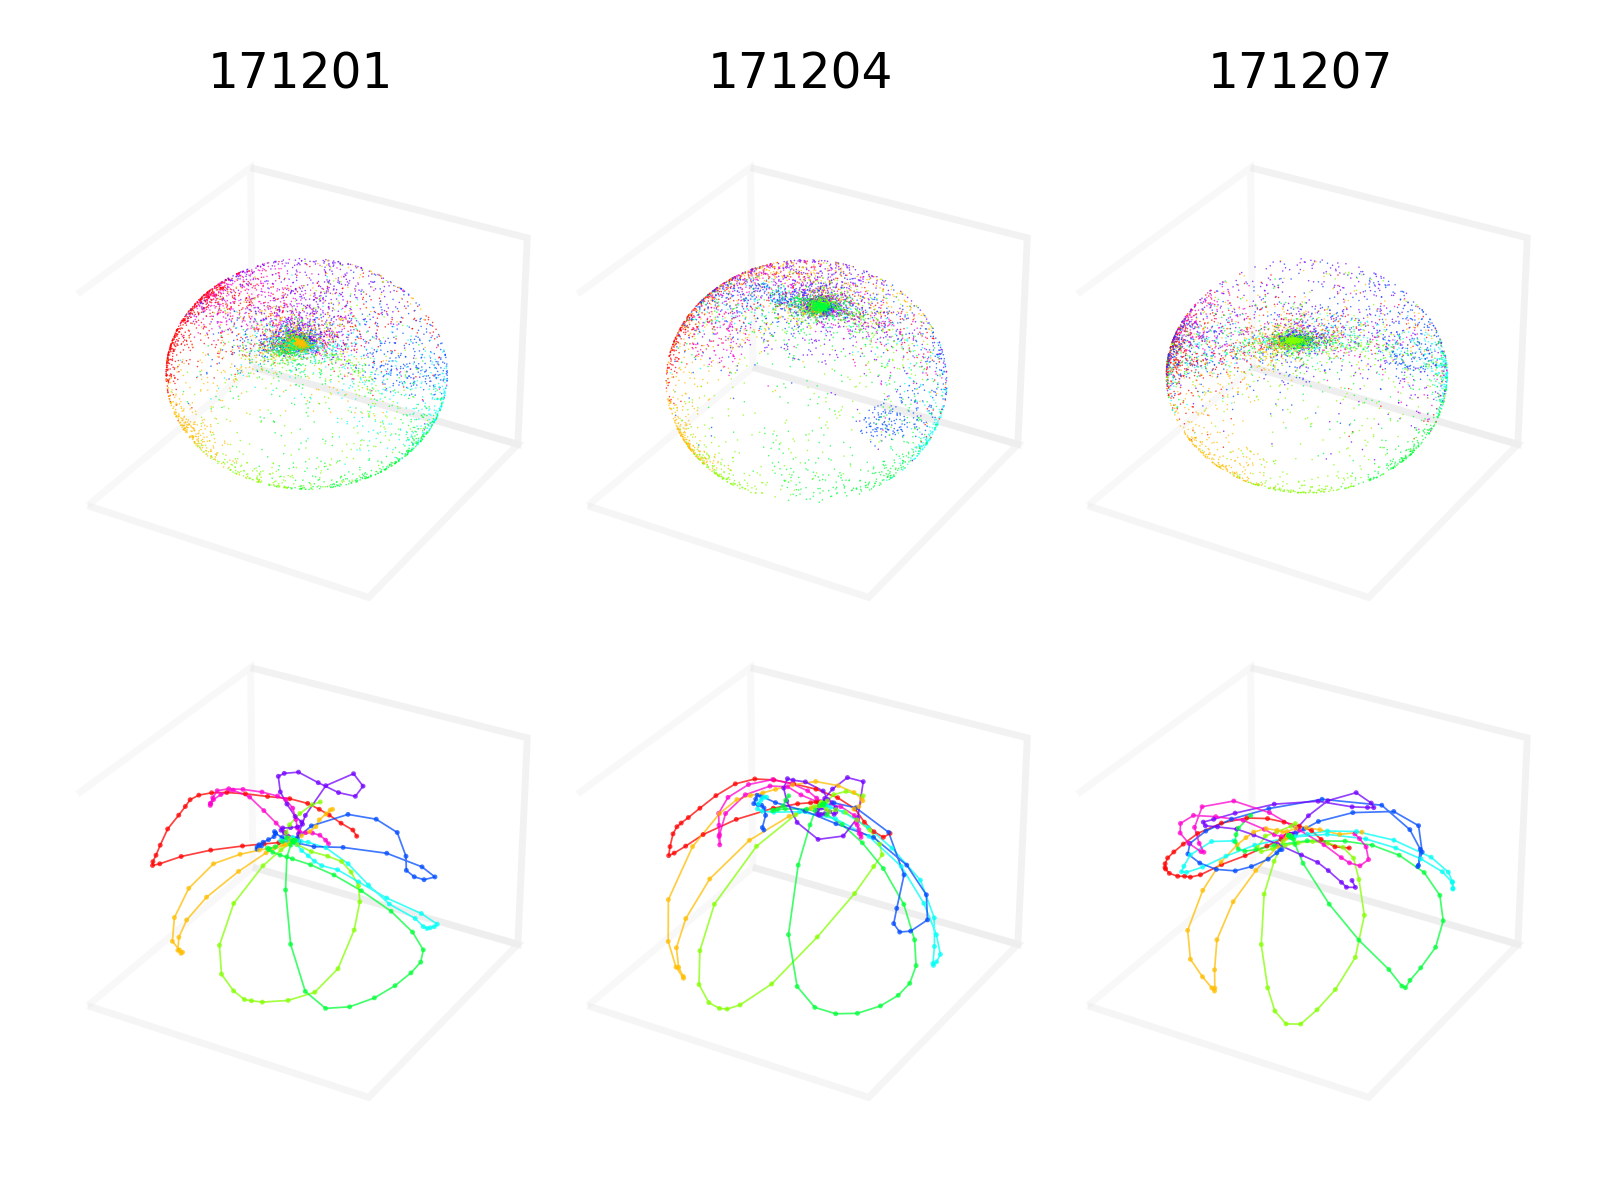

In [3]:
fig = plt.figure(figsize=(3, 2), dpi=500)
plt.subplots_adjust(wspace=0, hspace=0, top=1, bottom=0, left=0, right=1)
for f, file in enumerate(sorted_files):
    R_all = np.zeros((emb_dim, emb_dim, N_angles))
    for a in range(N_angles):
        data_single_session = np.load(file)
        emb_A = data_single_session['cebra_veldir_train']
        XYTarget_A = data_single_session['continuous_index_train']//45
        direction_trial = (XYTarget_A[:, 2] == a)
        trial_avg_A = emb_A[direction_trial, :].reshape(-1,dur,emb_dim).mean(axis=0)
        R, sca = orthogonal_procrustes(trial_avg_A, anchor_emb[:, :, a]) ### both are (dur, 3emb-dim)
        R_all[:,:, a] = R
        det_R = np.linalg.det(R)
        # print("Determinant of R:", det_R)
 
    trial_arrays = []
    for i in range(N_angles):
        direction_trial = (XYTarget_A[:, 2] == i)
        trial_A = emb_A[direction_trial, :].reshape(-1,dur,emb_dim)
        trial_A = np.matmul(trial_A, R_all[:,:,i])
        trial_arrays.append((direction_trial, trial_A))
    emb_A_8angle_align = np.empty_like(emb_A)
    for mask, trial_data in trial_arrays: ### loop-through 8 times=angles
        flat_data = trial_data.reshape(-1, emb_dim) ### (n-trials*dur, 3emb-dim)
        emb_A_8angle_align[mask, :] = flat_data
    
    emb_A_whole_align = np.matmul(emb_A, get_best_R(R_all, emb_A_8angle_align))
    
    #plt.subplots_adjust(hspace=0, wspace=0)
    ax = fig.add_subplot(2, n_file, f + 1, projection='3d')
    for i in range(N_angles):
        direction_trial = (XYTarget_A[:, 2] == i)
        trial_no_avg = emb_A_whole_align[direction_trial, :].reshape(-1,dur,emb_dim)
        ax.scatter(trial_no_avg[:, :, idx1],trial_no_avg[:, :, idx2],trial_no_avg[:, :, idx3],
                   color=plt.cm.hsv(1 / N_angles * i),edgecolors='none',alpha=0.75,s=0.05)
        ax.set_title(file[name_range], fontsize=7)
        ax.set_facecolor('white')  # Set the background color to white
        ax.grid(False)             # Remove the grid
        ax.xaxis.pane.fill = False # Remove the background panes
        ax.yaxis.pane.fill = False
        ax.zaxis.pane.fill = False
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_zticks([])
        ax.xaxis.line.set_color((1.0, 1.0, 1.0, 0.0)) # Remove the axis lines
        ax.yaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
        ax.zaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
        ax.xaxis.line.set_linewidth(0)   
    #plt.subplots_adjust(hspace=0, wspace=0)   
    ax = fig.add_subplot(2, n_file, n_file+f + 1, projection='3d')
#     plt.subplots_adjust(wspace=0)
    for i in range(N_angles):
        direction_trial = (XYTarget_A[:, 2] == i)
        trial_avg = emb_A_whole_align[direction_trial, :].reshape(-1,dur,emb_dim).mean(axis=0)
        ax.scatter(trial_avg[:, idx1],trial_avg[:, idx2],trial_avg[:, idx3],
                   color=plt.cm.hsv(1 / N_angles * i),edgecolors='none',alpha=0.75,s=0.5)
        ax.plot(trial_avg[:, idx1], trial_avg[:, idx2],trial_avg[:, idx3],
            color=plt.cm.hsv(1 / N_angles * i),linewidth=0.25, alpha=0.75)
        ax.set_facecolor('white')  # Set the background color to white
        ax.grid(False)             # Remove the grid
        ax.xaxis.pane.fill = False # Remove the background panes
        ax.yaxis.pane.fill = False
        ax.zaxis.pane.fill = False
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_zticks([])
        ax.xaxis.line.set_color((1.0, 1.0, 1.0, 0.0)) # Remove the axis lines
        ax.yaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
        ax.zaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
        ax.xaxis.line.set_linewidth(0)   
plt.savefig('./NER_Figs_pdf/Fig7/NER_After_rotate_Han2017_S1.pdf')